In [1]:
from typing import  List, Literal
import pandas as pd
from src.pipe_store import *
from lifelines import  KaplanMeierFitter
import matplotlib.pyplot as plt
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

In [4]:
path = '~/Global Data/20210614-mismatch_ep_db-extended.pickle'
donor_type ='Deceased'
status = 'All'

df = (
    data_loading(path)
    .pipe(start_pipeline, status, donor_type)
    .pipe(keeping_features,
        'TransplantID',
        'Failure',
        'Survival[Y]',
        'EpvsHLA_Donor',
        '#DESA',
        'DESA', 
    )
    .pipe(set_time_event_label, E='Failure', T='Survival[Y]')
    .pipe(setting_prediction_horizon, 15)
)
epitope_path = '~/Global Data/EpitopevsHLA.pickle'
epitope_db = pd.read_pickle(epitope_path)

In [6]:
def get_epitopes_ellipro_scores(df, scores:List[Literal['Very Low', 'Low', 'Intermediate', 'High']]=None):
    if not scores:
        scores = ['Very Low', 'Low', 'Intermediate', 'High']
    score_epitope = {score : set(df[df['ElliPro Score'] == score].Epitope.values) for score in scores}
    assert len(df) == sum([len(score_epitope[item]) for item in score_epitope])
    return score_epitope

def categorizer(epitopes, ellipro_cat_epitopes, output:Literal['#Epitope', 'Epitope']='Epitope'):
    if epitopes and (intersect := epitopes.intersection(ellipro_cat_epitopes)):
        return {'#Epitope': len(intersect), 'Epitope': intersect}.get(output)
    return 0


def categorize_per_elliproscore(df,
                                score_vs_ep:dict,
                                output:Literal['Number', 'Epitope']='Epitope',
                                scores:List[Literal['Very Low', 'Low', 'Intermediate', 'High']]=None):
    df = df.copy(deep=True)
    if not scores:
        scores = ['Very Low', 'Low', 'Intermediate', 'High']
    for score in scores:
        df[score] = df['DESA'].apply(categorizer, args=(score_vs_ep[score], output,))
    return df
    

In [7]:
score_vs_ep = get_epitopes_ellipro_scores(epitope_db)

In [8]:
# score_vs_ep
df_new = categorize_per_elliproscore(df, score_vs_ep, output='#Epitope')

In [9]:
col_ellipro = ['Very Low', 'Low', 'Intermediate', 'High']
df_dead = df_new[df_new['#DESA'].ge(1)]

In [10]:
import numpy as np

df_dead = df_dead.assign(
    score = df_dead[col_ellipro].apply(lambda x: np.dot(x[col_ellipro], [0, 1, 2, 3]), axis=1)
)

In [11]:
df_dead_early = df_dead[(df_dead['E'] == 1) & (df_dead['T'] <= 1)]
df_dead_late = df_dead[(df_dead['E'] == 0) & (df_dead['T'] >= 12)]

In [12]:
df_dead_early.shape, df_dead_late.shape

((61, 11), (66, 11))

In [13]:
df_dead_late = df_dead_late.sample(61)
df_dead_early.shape, df_dead_late.shape

((61, 11), (61, 11))

In [14]:
df_dead_early =  df_dead_early.assign(period = 'early')
df_dead_late =  df_dead_late.assign(period = 'late')

In [15]:
df_both = pd.concat([df_dead_early, df_dead_late]).reset_index(drop=True)
df_both

,TransplantID,EpvsHLA_Donor,#DESA,DESA,E,T,Very Low,Low,Intermediate,High,score,period
0,327,"{'62GE': 'B*57:01', '62GRN': 'B*57:01', '74Y':...",7,"{97V, 94I, 62GRN, 44RMA, 62GE, 74Y, 71SA}",True,0.287671,1,3,1,2,11,early
1,279,"{'13SE': 'DRB3*03:01', '181T': 'DRB3*03:01', '...",25,"{31FH, 25R, 70Q, 149H, 98KS, 13SE, 67LQ, 11STS...",True,0.000000,2,2,5,16,60,early
2,678,"{'185I': 'DQB1*04:02', '55R': 'DQB1*04:02', '4...",21,"{55R, 37YV[DR], 74S, 37YA, 46VY, 77T[DQ], 56L,...",True,0.087671,0,1,1,19,60,early
3,1382,"{'45EV': 'DQB1*03:01', '55PPD': 'DQB1*03:01', ...",3,"{45EV, 55PPD, 55PP}",True,0.005479,0,0,0,3,9,early
4,5968,"{'37S': 'DRB1*16:01', '142M': 'DRB1*16:01', '9...",8,"{108T, 30G[DR], 37S, 142M, 28H, 96EV, 71A, 6C}",True,0.065753,0,1,2,5,20,early
...,...,...,...,...,...,...,...,...,...,...,...,...
117,35,"{'80K': 'C*05:01', '138K': 'C*05:01'}",2,"{138K, 80K}",False,14.057534,0,0,0,2,6,late
118,2333,"{'116L': 'C*15:02', '52LL': 'DQB1*02:01'}",2,"{116L, 52LL}",False,15.000000,1,0,0,1,3,late
119,2204,"{'185I': 'DQB1*04:02', '77T[DQ]': 'DQB1*04:02'...",6,"{185I, 56L, 37YA, 182N, 9F[DQ], 77T[DQ]}",False,12.008219,0,1,0,5,16,late
120,4155,"{'37YV[DR]': 'DRB1*11:04', '57DE': 'DRB1*11:04...",7,"{57DE, 70QQ, 37YV[DR], 73GQ, 98Q, 104AK, 51R}",False,12.712329,0,0,1,6,20,late


# Checking distributions in Score

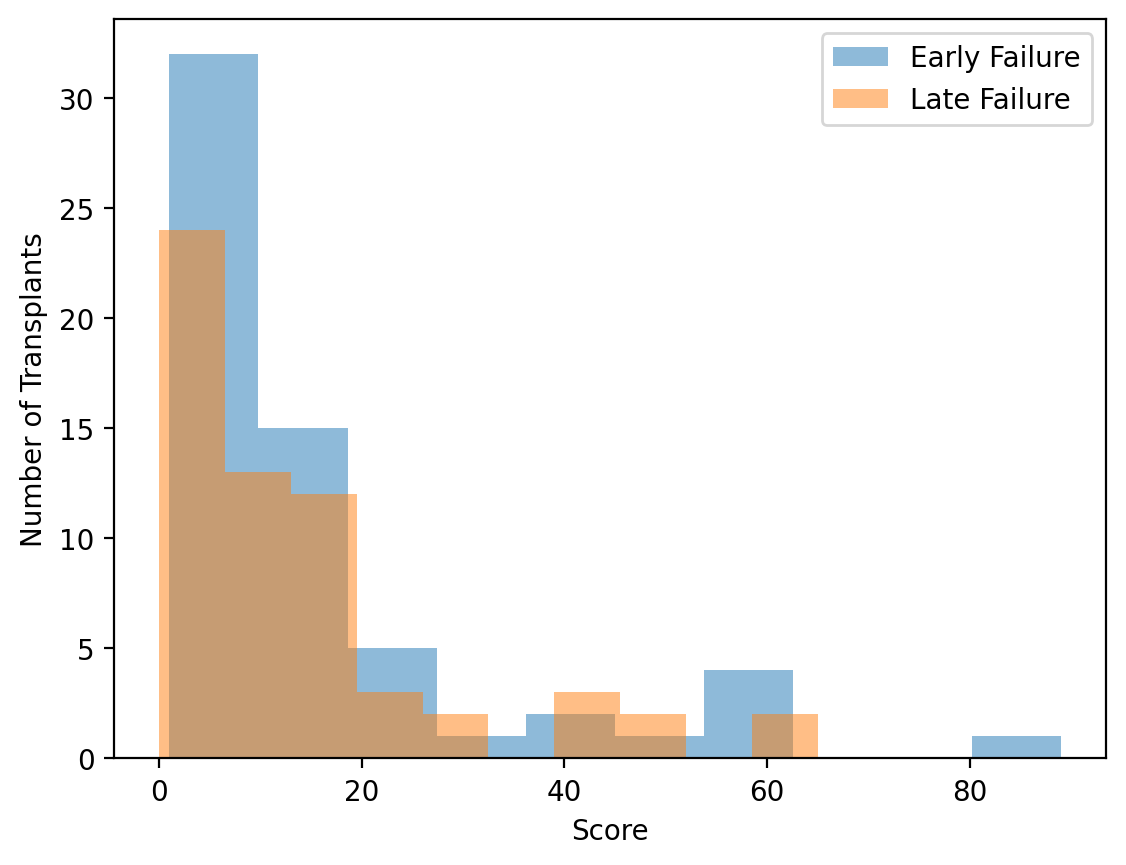

In [18]:
import matplotlib.pyplot as plt

df_dead_early['score'].plot.hist(alpha=0.5, label='Early Failure')
df_dead_late['score'].plot.hist(alpha=0.5, label='Late Failure')
plt.ylabel('Number of Transplants')
plt.xlabel('Score')
plt.legend();

In [ ]:
# df_dead_early['High'].plot.hist(alpha=0.5)
# df_dead_late['High'].plot.hist(alpha=0.5)

In [ ]:
# df_dead_early['Intermediate'].plot.hist(alpha=0.5)
# df_dead_late['Intermediate'].plot.hist(alpha=0.5)

In [ ]:
# df_dead_early['Low'].plot.hist(alpha=0.5)
# df_dead_late['Low'].plot.hist(alpha=0.5)

# Causal Analysis

In [ ]:
# path_cohort = '~/UMCUtrecht/KaplanMeier/DESAsurvival.pickle'
# path_antibody = '~/UMCUtrecht/20211104_mismatch_ep_db.pickle'
# df_abs = pd.read_pickle(path_antibody)
# df_cohort = pd.read_pickle(path_cohort)
# df = df_abs.merge(df_cohort, on='TransplantID')
# print(df.columns)
# cols = [
#     'TransplantID', 'DESA_Status', 'EpvsHLA_Donor', '#DESA', 'DESA', 'RecipientAge_NOTR', 
#     'DonorAge_NOTR', 'TypeOfDonor_NOTR', 'FailureCode10Y_R', 'GraftSurvival10Y_R', 'IL2rMoAb',
#     'CIPHour_DBD', 'CIPHour_DCD' , 'LivingDonorNum', # 'FailureCode10y'
# ]
# df = df[cols]

# Cox PH Analysis with Continuous Treatment (Scores)

In [19]:
path = '~/Global Data/20210614-mismatch_ep_db-extended.pickle'
num_col = ['DonorAge_NOTR', 'DialysisYears', 'RecipientAge_NOTR', 'CIPHour_DBD', 'CIPHour_DCD']

df = (
    data_loading(path)
    .pipe(keeping_features,
        'TransplantID',
        'Failure',
        'Survival[Y]',
        'EpvsHLA_Donor',
        '#DESA',
        'DESA', 
        'DonorAge_NOTR',
        'DialysisYears',
        'RecipientAge_NOTR',
        'CIPHour_DBD', 
        'CIPHour_DCD' ,
        'Donor_Type',
        'IL2rMoAb_T0'
    )
    .pipe(integer_encoder, 'IL2rMoAb_T0')
    .pipe(polynomial_power2, 'DonorAge_NOTR', 'RecipientAge_NOTR')
    .pipe(set_time_event_label, E='Failure', T='Survival[Y]')
    # .pipe(eng_immunological_features, antibody_epitope=True)
    .pipe(feature_scaler, num_col + ['DonorAge_NOTR_power2', 'RecipientAge_NOTR_power2'], scaler='maxmin')
    .pipe(censoring_deaths)
    # .pipe(setting_prediction_horizon, 15)
    .rename(columns={'IL2rMoAb_T0':'IL2rMoAb'})
)


In [20]:
# df_both = df_both[['TransplantID', 'period', 'score']].merge(df, on='TransplantID')
df

,TransplantID,EpvsHLA_Donor,#DESA,DESA,DonorAge_NOTR,DialysisYears,RecipientAge_NOTR,CIPHour_DBD,CIPHour_DCD,Donor_Type,IL2rMoAb,DonorAge_NOTR_power2,RecipientAge_NOTR_power2,E,T
0,4036,{},0,{},0.488889,0.076923,0.670886,0.168172,0.000000,Deceased,0,0.239012,0.455540,0,12.191781
1,2809,{},0,{},0.600000,0.070234,0.392405,0.406415,0.000000,Deceased,0,0.360000,0.159869,0,17.010959
2,862,{},0,{},0.488889,0.163880,0.329114,0.672688,0.000000,Deceased,0,0.239012,0.113768,1,6.956164
3,3549,{},0,{},0.255556,0.000000,0.493671,0.560573,0.000000,Deceased,1,0.065309,0.249883,1,4.509589
4,12,{},0,{},0.611111,0.180602,0.468354,0.000000,0.400388,Deceased,0,0.373457,0.225504,1,0.010959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4685,994,{},0,{},0.566667,0.050167,0.531646,0.541887,0.000000,Deceased,1,0.321111,0.288795,1,12.126027
4686,995,{},0,{},0.600000,0.056856,0.455696,0.386795,0.000000,Deceased,1,0.360000,0.213783,1,10.879452
4687,996,{},0,{},0.233333,0.117057,0.569620,0.321084,0.000000,Deceased,1,0.054444,0.330520,0,18.010959
4688,997,{},0,{},0.466667,0.083612,0.278481,0.000000,0.748450,Deceased,1,0.217778,0.082513,1,11.816438


In [21]:
# cols = ['TransplantID', 'Very Low', 'Low', 'Intermediate', 'High',	'score']
cols_final = ['TransplantID', 'RecipientAge_NOTR', 'DonorAge_NOTR', 'IL2rMoAb', 'CIPHour_DBD', 'CIPHour_DCD']

def cat_transformer(_df, df):

    return (
        _df[['TransplantID', 'period', 'score']]
        .merge(df, on='TransplantID')
        .assign(
            score_low = lambda x: x['score'].apply(lambda x: 1 if x <= 20 else 0),
            # score_medium = lambda x: x['score'].apply(lambda x: 1 if (x > 20 and x <= 40) else 0),
            score_high =  lambda x: x['score'].apply( lambda x: 1 if x > 20 else 0),
        )
    )

In [22]:
df_both = cat_transformer(df_both, df)

In [23]:
df_both

,TransplantID,period,score,EpvsHLA_Donor,#DESA,DESA,DonorAge_NOTR,DialysisYears,RecipientAge_NOTR,CIPHour_DBD,CIPHour_DCD,Donor_Type,IL2rMoAb,DonorAge_NOTR_power2,RecipientAge_NOTR_power2,E,T,score_low,score_high
0,327,early,11,"{'62GE': 'B*57:01', '62GRN': 'B*57:01', '74Y':...",7,"{97V, 94I, 62GRN, 44RMA, 62GE, 74Y, 71SA}",0.388889,0.123746,0.493671,0.000000,0.534884,Deceased,0,0.151235,0.249883,1,0.287671,1,0
1,279,early,60,"{'13SE': 'DRB3*03:01', '181T': 'DRB3*03:01', '...",25,"{31FH, 25R, 70Q, 149H, 98KS, 13SE, 67LQ, 11STS...",0.255556,0.264214,0.354430,0.409218,0.000000,Deceased,1,0.065309,0.131271,1,0.000000,0,1
2,678,early,60,"{'185I': 'DQB1*04:02', '55R': 'DQB1*04:02', '4...",21,"{55R, 37YV[DR], 74S, 37YA, 46VY, 77T[DQ], 56L,...",0.611111,0.033445,0.746835,0.000000,0.406977,Deceased,0,0.373457,0.562432,1,0.087671,0,1
3,1382,early,9,"{'45EV': 'DQB1*03:01', '55PPD': 'DQB1*03:01', ...",3,"{45EV, 55PPD, 55PP}",0.577778,0.053512,0.582278,0.000000,0.414729,Deceased,0,0.333827,0.345054,1,0.005479,1,0
4,5968,early,20,"{'37S': 'DRB1*16:01', '142M': 'DRB1*16:01', '9...",8,"{108T, 30G[DR], 37S, 142M, 28H, 96EV, 71A, 6C}",0.177778,0.100334,0.784810,0.000000,0.567054,Deceased,1,0.031605,0.620097,1,0.065753,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,35,late,6,"{'80K': 'C*05:01', '138K': 'C*05:01'}",2,"{138K, 80K}",0.400000,0.117057,0.632911,0.298972,0.000000,Deceased,1,0.160000,0.406313,0,14.057534,1,0
118,2333,late,3,"{'116L': 'C*15:02', '52LL': 'DQB1*02:01'}",2,"{116L, 52LL}",0.222222,0.080268,0.481013,0.298972,0.000000,Deceased,1,0.049383,0.237537,0,16.882192,1,0
119,2204,late,16,"{'185I': 'DQB1*04:02', '77T[DQ]': 'DQB1*04:02'...",6,"{185I, 56L, 37YA, 182N, 9F[DQ], 77T[DQ]}",0.500000,0.030100,0.430380,0.504516,0.000000,Deceased,1,0.250000,0.191280,0,12.008219,1,0
120,4155,late,20,"{'37YV[DR]': 'DRB1*11:04', '57DE': 'DRB1*11:04...",7,"{57DE, 70QQ, 37YV[DR], 73GQ, 98Q, 104AK, 51R}",0.355556,0.100334,0.620253,0.504516,0.000000,Deceased,1,0.126420,0.390530,0,12.712329,1,0


In [24]:
confounders = [
    'RecipientAge_NOTR', 
    'RecipientAge_NOTR_power2',
    'DonorAge_NOTR',
    'DonorAge_NOTR_power2',
    # 'IL2rMoAb', 
    'CIPHour_DBD', 'CIPHour_DCD', 
    'DialysisYears',
    # 'score', 
    # 'score_low', 
    # 'score_medium', 
    'score_high',
]

In [25]:
from lifelines import CoxPHFitter
formula = ' + '.join(confounders)
df_both = df_both.pipe(feature_scaler, ['score'], scaler='maxmin')

df_l = df_both[df_both.period.eq('early')]
cph = CoxPHFitter()
cph.fit(df_l, duration_col='T', event_col='E', formula=formula)
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 61 total observations, 0 right-censored observations>
             duration col = 'T'
                event col = 'E'
      baseline estimation = breslow
   number of observations = 61
number of events observed = 61
   partial log-likelihood = -189.13
         time fit was run = 2023-07-17 20:56:58 UTC

---
                           coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                        
CIPHour_DBD               -1.54       0.21       1.12            -3.73             0.65                 0.02                 1.91
CIPHour_DCD               -1.30       0.27       1.07            -3.39             0.79                 0.03                 2.21
DialysisYears             -2.90       0.06       1.84            -6.50             0.70                 0.00                 2.02
DonorAge_NOTR             -5.17       0.01       3.07           -11.18             0.85                 0.00                 2.34
DonorAge_NOTR_power2       5.66     287.75       3.70            -1.59            12.92                 0.20             4.08e+05
RecipientAge_NOTR          2.61      13.65       4.46            -6.13            11.36                 0.00             85835.90
RecipientAge_NOTR_power2  -2.40       0.09       4.19           -10.61             5.82                 0.00               336.09
score_high                -0.17       0.84       0.37            -0.89             0.55                 0.41                 1.72

                             z    p   -log2(p)
covariate                                     
CIPHour_DBD              -1.38 0.17       2.58
CIPHour_DCD              -1.22 0.22       2.16
DialysisYears            -1.58 0.11       3.12
DonorAge_NOTR            -1.68 0.09       3.44
DonorAge_NOTR_power2      1.53 0.13       2.99
RecipientAge_NOTR         0.59 0.56       0.84
RecipientAge_NOTR_power2 -0.57 0.57       0.82
score_high               -0.47 0.64       0.65
---
Concordance = 0.60
Partial AIC = 394.27
log-likelihood ratio test = 7.21 on 8 df
-log2(p) of ll-ratio test = 0.96

In [26]:
cph.check_assumptions(df_both[df_both.period.eq('early')], p_value_threshold=0.05, show_plots=True)

Proportional hazard assumption looks okay.


/home/lcreteig/.local/share/virtualenvs/desa_paper-0PNgmhA7/lib/python3.8/site-packages/lifelines/fitters/mixins.py:108: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  for variable in self.params_.index & (columns or self.params_.index):


[]

In [27]:
from lifelines import CoxPHFitter
formula = ' + '.join(confounders)
df_both = df_both.pipe(feature_scaler, ['score'], scaler='maxmin')

df_l = df_both[df_both.period.eq('late')]
cph = CoxPHFitter()
cph.fit(df_l, duration_col='T', event_col='E', formula=formula)
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 61 total observations, 51 right-censored observations>
             duration col = 'T'
                event col = 'E'
      baseline estimation = breslow
   number of observations = 61
number of events observed = 10
   partial log-likelihood = -23.71
         time fit was run = 2023-07-17 20:57:15 UTC

---
                           coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                        
CIPHour_DBD               -0.64       0.53       3.64            -7.77             6.50                 0.00               664.56
CIPHour_DCD                2.52      12.44       4.12            -5.56            10.60                 0.00             40060.11
DialysisYears              2.25       9.46       3.26            -4.15             8.64                 0.02              5678.40
DonorAge_NOTR              9.44   12628.37      13.90           -17.80            36.69                 0.00             8.56e+15
DonorAge_NOTR_power2     -16.09       0.00      18.12           -51.60            19.42                 0.00             2.73e+08
RecipientAge_NOTR        -20.10       0.00       9.75           -39.21            -1.00                 0.00                 0.37
RecipientAge_NOTR_power2  21.45   2.07e+09       9.94             1.97            40.94                 7.15             6.01e+17
score_high                -2.19       0.11       2.16            -6.43             2.04                 0.00                 7.68

                             z    p   -log2(p)
covariate                                     
CIPHour_DBD              -0.18 0.86       0.22
CIPHour_DCD               0.61 0.54       0.89
DialysisYears             0.69 0.49       1.03
DonorAge_NOTR             0.68 0.50       1.01
DonorAge_NOTR_power2     -0.89 0.37       1.42
RecipientAge_NOTR        -2.06 0.04       4.67
RecipientAge_NOTR_power2  2.16 0.03       5.01
score_high               -1.02 0.31       1.69
---
Concordance = 0.78
Partial AIC = 63.42
log-likelihood ratio test = 10.85 on 8 df
-log2(p) of ll-ratio test = 2.25

In [28]:
cph.check_assumptions(df_both[df_both.period.eq('late')], p_value_threshold=0.05, show_plots=True)

Proportional hazard assumption looks okay.


/home/lcreteig/.local/share/virtualenvs/desa_paper-0PNgmhA7/lib/python3.8/site-packages/lifelines/fitters/mixins.py:108: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  for variable in self.params_.index & (columns or self.params_.index):


[]

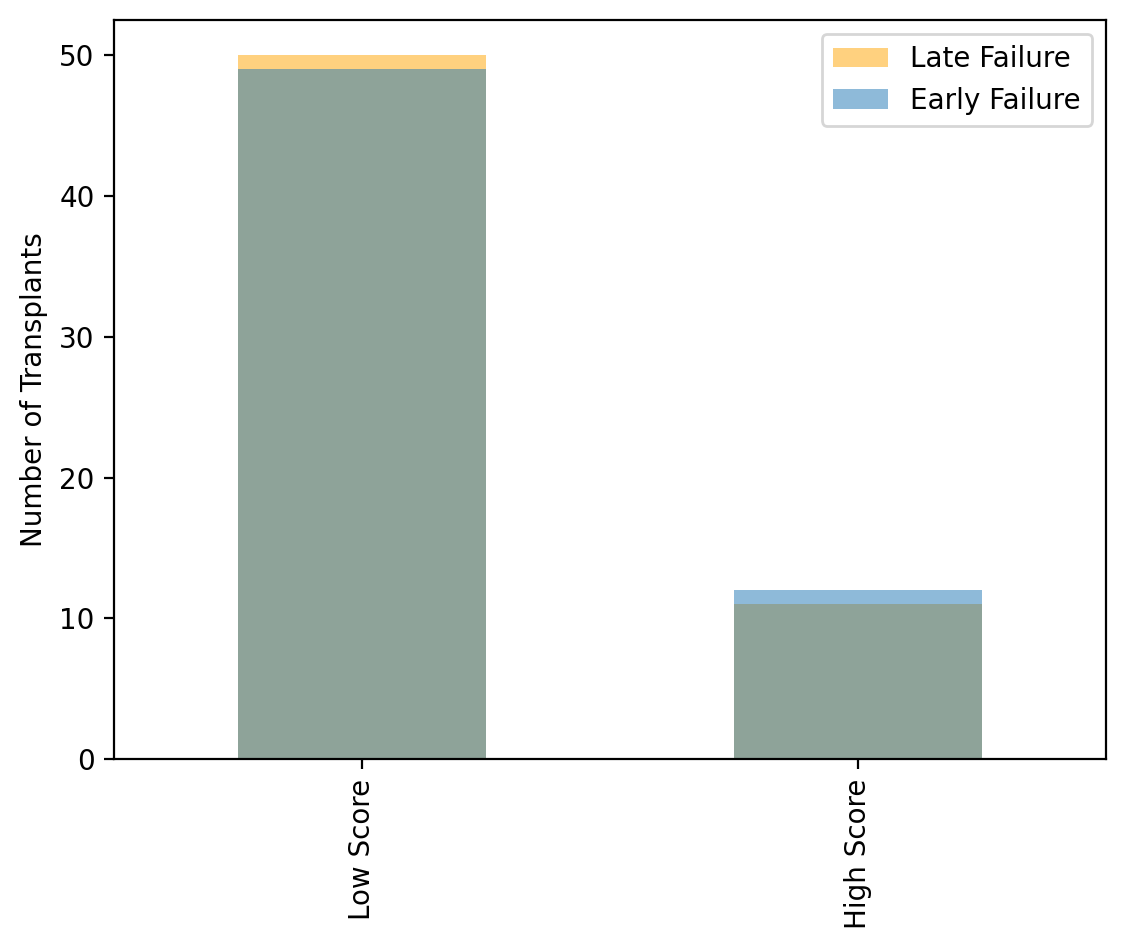

In [29]:
df_both[df_both.period.eq('late')]['score_high'].value_counts().plot.bar(alpha=0.5, color='orange', label='Late Failure')
df_both[df_both.period.eq('early')]['score_high'].value_counts().plot.bar(alpha=0.5, label='Early Failure')
plt.xticks([0, 1], ['Low Score', 'High Score'])
plt.ylabel('Number of Transplants')
plt.legend()

In [ ]:
# df_both[df_both.period.eq('late')]['score_medium'].plot.hist(alpha=0.5)
# df_both[df_both.period.eq('early')]['score_medium'].plot.hist(alpha=0.5)

<AxesSubplot:ylabel='Frequency'>

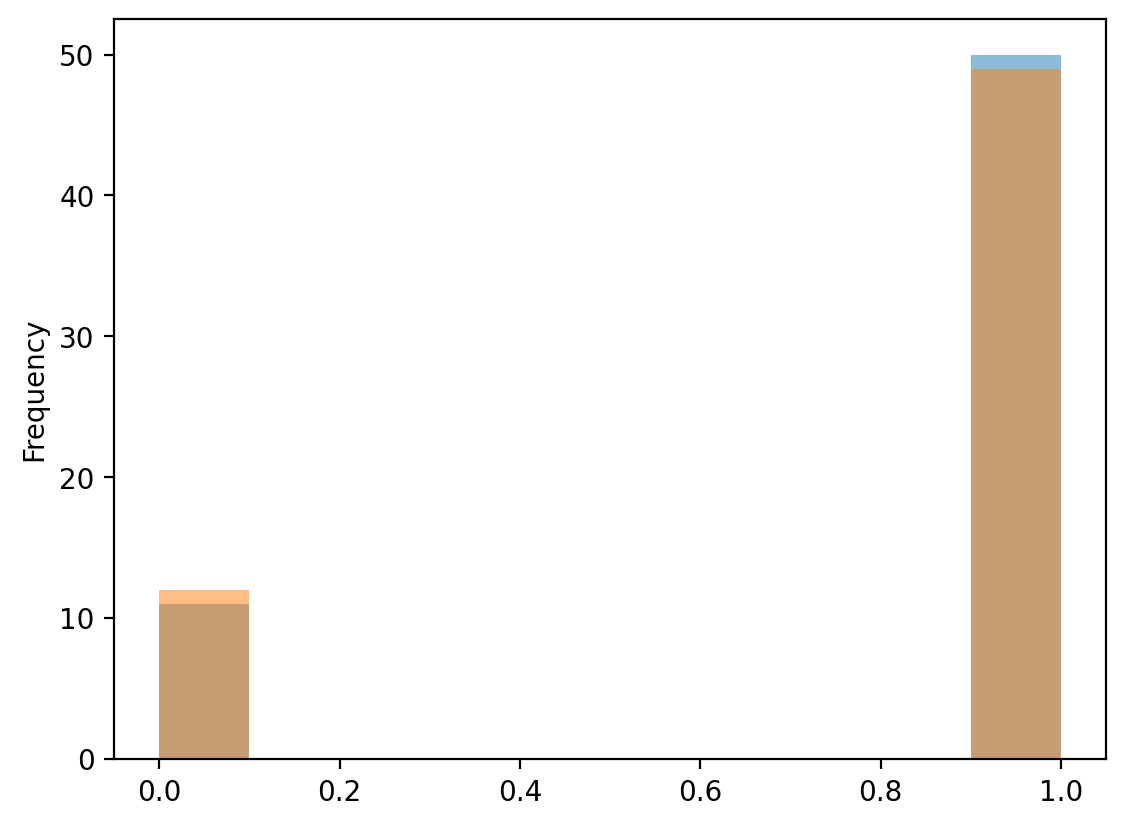

In [30]:
df_both[df_both.period.eq('late')]['score_low'].plot.hist(alpha=0.5)
df_both[df_both.period.eq('early')]['score_low'].plot.hist(alpha=0.5)

# Kaplan Meier Curves

<AxesSubplot:xlabel='timeline'>

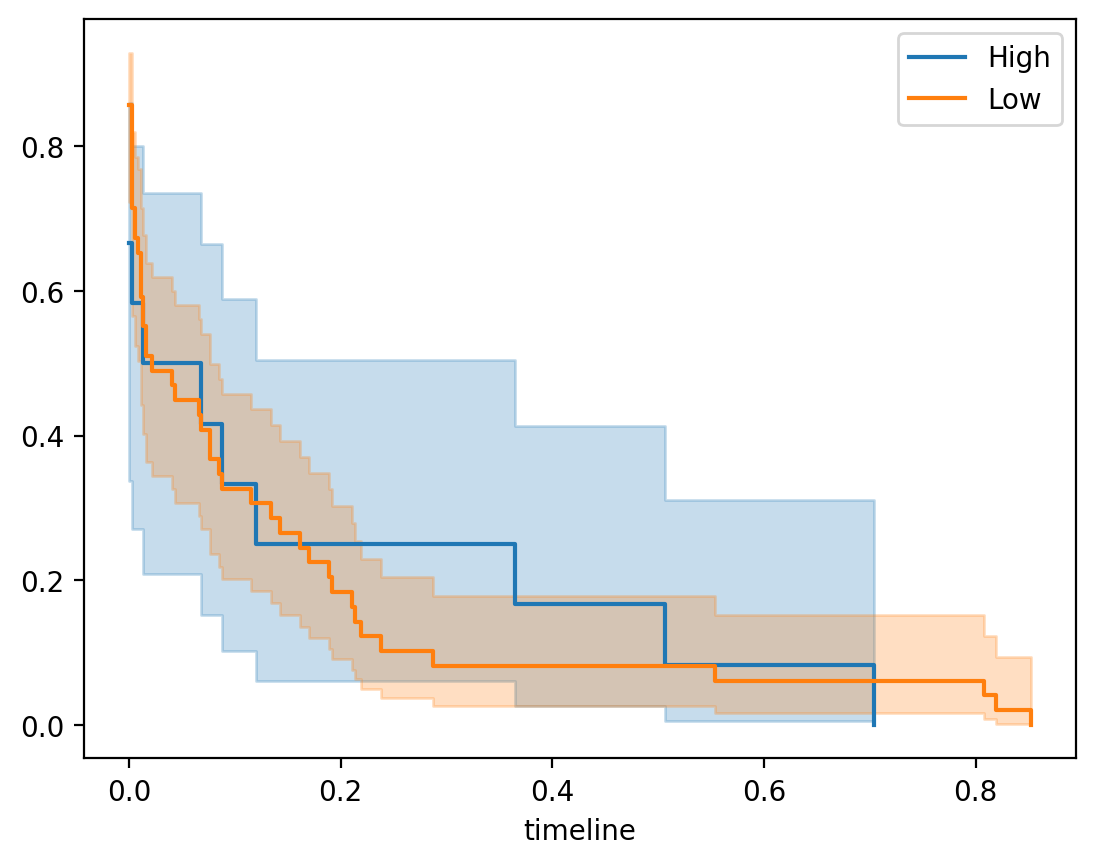

In [31]:
from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts
from matplotlib.offsetbox import AnchoredText

kmf = KaplanMeierFitter()

ax = plt.subplot(111)

ind_period = df_both['period'].eq('early')
ind_high = df_both['score_high'].eq(1)

kmf.fit(df_both[ind_period & ind_high]['T'], event_observed=df_both[ind_period & ind_high]['E'], label="High")
kmf.plot_survival_function(ax=ax)

kmf.fit(df_both[ind_period & ~ind_high]['T'], event_observed=df_both[ind_period & ~ind_high]['E'], label="Low")
kmf.plot_survival_function(ax=ax)


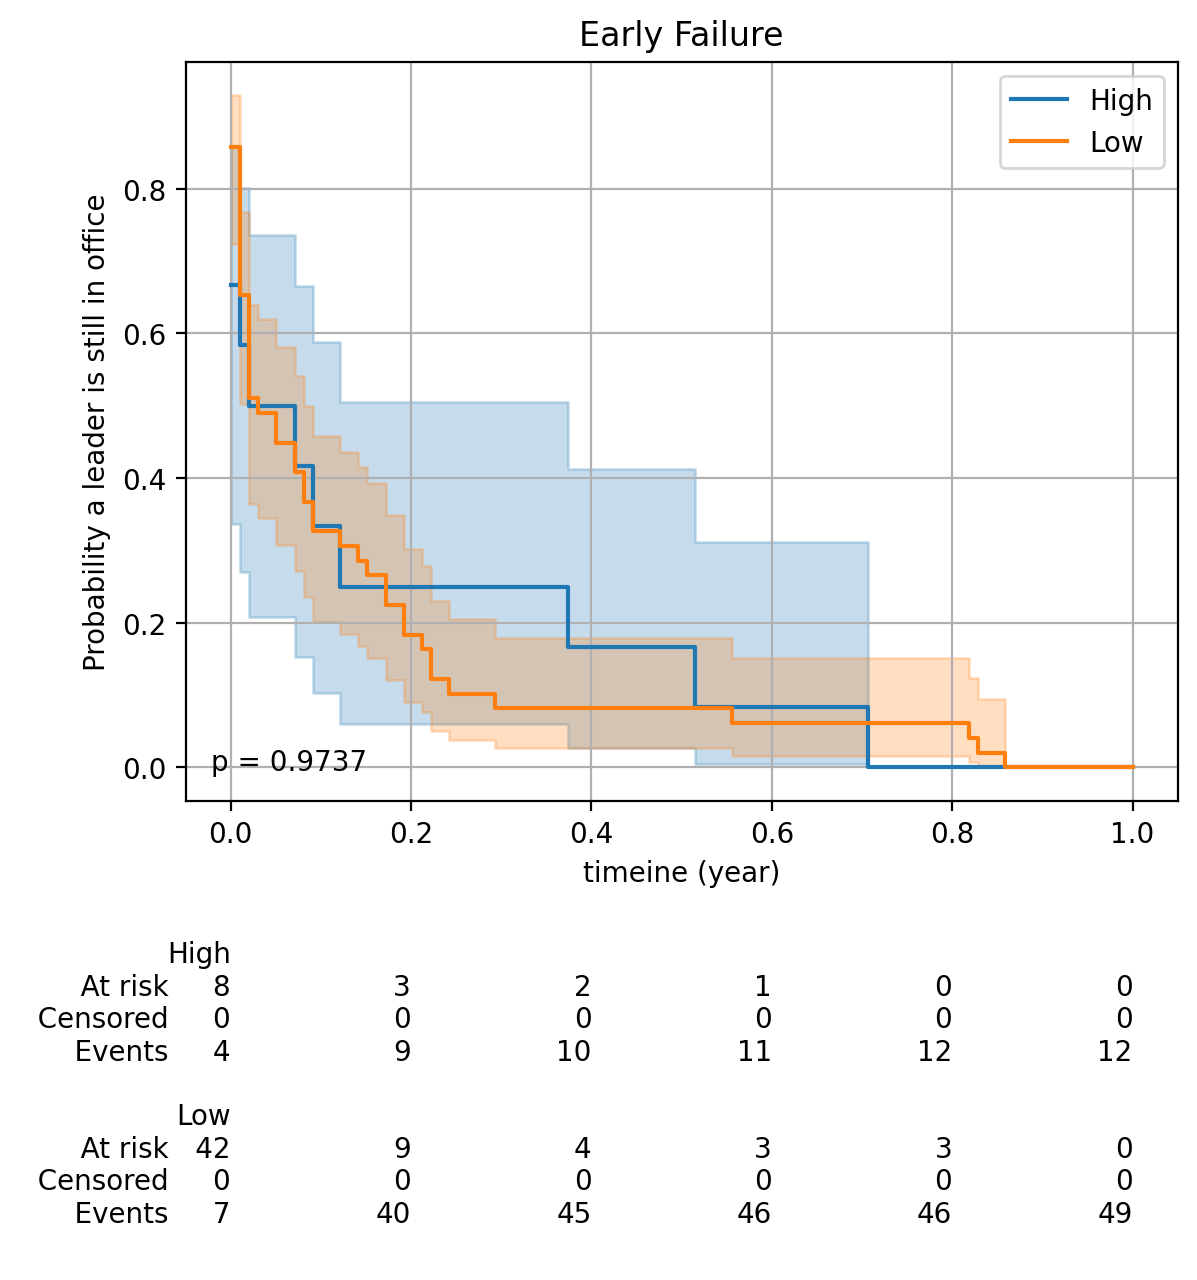

In [40]:
kmf1 = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()
ax = plt.subplot(111)

t = np.linspace(0, 1, 100)

ind_period = df_both['period'].eq('early')
ind_high = df_both['score_high'].eq(1)
ind_1 = ind_period & ind_high
ind_2 = ind_period & ~ind_high

kmf1.fit(df_both[ind_1]['T'], event_observed=df_both[ind_1]['E'], timeline=t, label="High")
kmf1.plot_survival_function(ax=ax)

kmf2.fit(df_both[ind_2]['T'], event_observed=df_both[ind_2]['E'],  timeline=t, label="Low")
kmf2.plot_survival_function(ax=ax)


add_at_risk_counts(kmf1, kmf2, ax=ax, fontsize=10, rows_to_show=["At risk", "Censored", "Events"])


# Calculate statistical significance
from lifelines.statistics import logrank_test
log_rank_test_result = logrank_test(df_both[ind_1]['T'], df_both[ind_2]['T'], event_observed_A=df_both[ind_1]['E'], event_observed_B=df_both[ind_2]['E'])
p_value = log_rank_test_result.p_value

p_value_string = 'p < 0.0001' if p_value < 0.0001 else f'p = {p_value:.4f}'
ax.add_artist(AnchoredText(p_value_string, loc=3, frameon=False))

ax.yaxis.grid() # horizontal lines
ax.xaxis.grid()
ax.set_xlabel("timeine (year)");
ax.set_ylabel("Probability a leader is still in office");
plt.title('Early Failure')
plt.show();

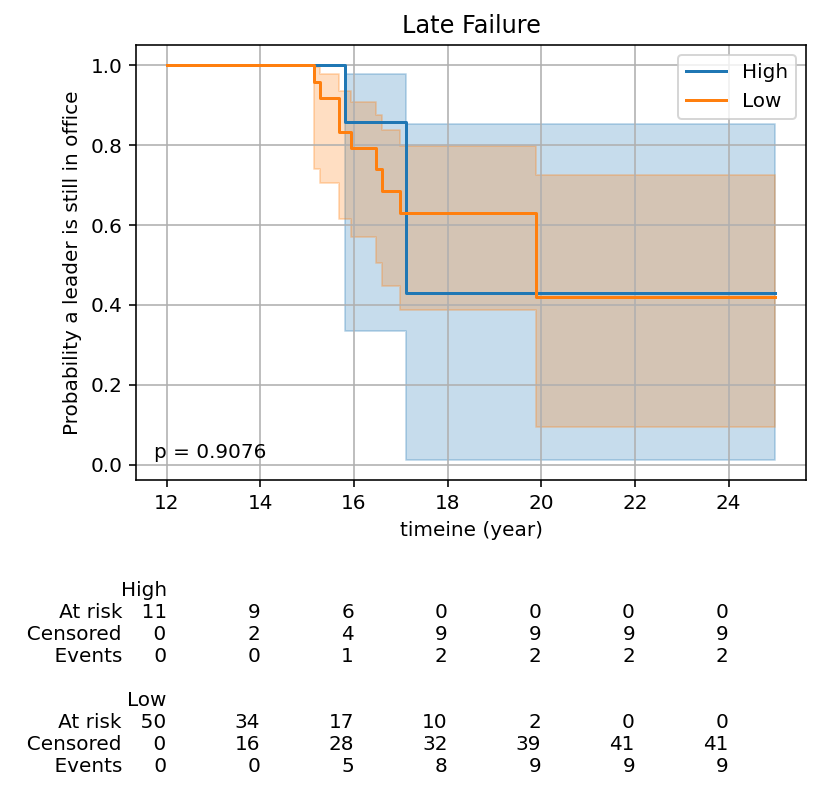

In [ ]:
kmf1 = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()
ax = plt.subplot(111)

t = np.linspace(12, 25, 100)

ind_period = df_both['period'].eq('late')
ind_high = df_both['score_high'].eq(1)
ind_1 = ind_period & ind_high
ind_2 = ind_period & ~ind_high

kmf1.fit(df_both[ind_1]['T'], event_observed=df_both[ind_1]['E'], timeline=t, label="High")
kmf1.plot_survival_function(ax=ax)

kmf2.fit(df_both[ind_2]['T'], event_observed=df_both[ind_2]['E'],  timeline=t, label="Low")
kmf2.plot_survival_function(ax=ax)


add_at_risk_counts(kmf1, kmf2, ax=ax, fontsize=10, rows_to_show=["At risk", "Censored", "Events"])


# Calculate statistical significance
from lifelines.statistics import logrank_test
log_rank_test_result = logrank_test(df_both[ind_1]['T'], df_both[ind_2]['T'], event_observed_A=df_both[ind_1]['E'], event_observed_B=df_both[ind_2]['E'])
p_value = log_rank_test_result.p_value

p_value_string = 'p < 0.0001' if p_value < 0.0001 else f'p = {p_value:.4f}'
ax.add_artist(AnchoredText(p_value_string, loc=3, frameon=False))

ax.yaxis.grid() # horizontal lines
ax.xaxis.grid()
ax.set_xlabel("timeine (year)");
ax.set_ylabel("Probability a leader is still in office");
plt.title('Late Failure')
plt.show();